# OU Fitter without jumps

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ito_diffusions import *
from ou_fitter import *
from scipy.stats import laplace
plt.style.use('dark_background')

In [3]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [4]:
DAYS_IN_YEAR = 252
T = 8
SCHEME_STEPS = int(DAYS_IN_YEAR*T)

std_dev_weight = 1.0
n_quadrature = 15

### OU process

$ dX_t = \lambda(\theta_0 - X_t)dt + \sigma{dW_t}$ 

$ dX_t = mean\_reversion * (long\_term - X_t) * dt + vol * dW_t $

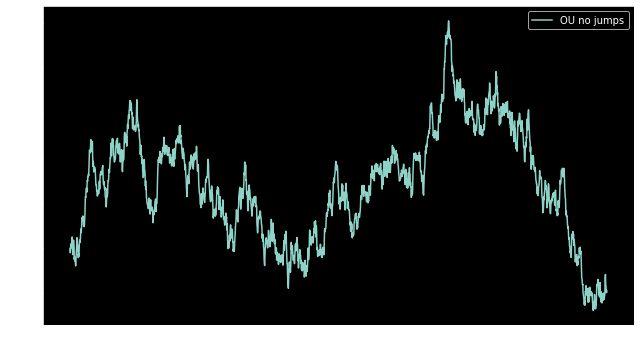

In [5]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 1.0
long_term = 0.0
vol = 0.4

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
            )

df = OU.simulate()

ax.plot(df, label='OU no jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Estimate all parameters at once

Main issue here is identifiability of the model : in stationary mode, the Ornstein-Uhlenbeck distribution depends on the long-term mean and $\sigma^2 / \lambda$, thus estimating both volatility and mean-reversion can only be done up to a scaling factor.

This creates instability in the optimization routine and strongly varying results depending on the starting point of the calibration.

The result of the characteristic function fitting is compared to values obtained by regression (mean-reversion is the slope of the regression of increments to the series of $X_t$, volatility is the standard deviation of the time-scaled increments).

In [6]:
fitter = OU_no_jump_fitter(theta_init_mode='random',
                           std_dev_weight=std_dev_weight,
                           n_quadrature=n_quadrature)
fitter.df = df
fitter.regularization = 1e-4
fitter.theta_init

[1.3106667207444918, 0.9962052692268952, 0.4863755130826365]

In [7]:
fit_info = fitter.fit()
fit_info

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.8851717251077252e-05
        x: [ 8.764e-03  2.854e-01  3.221e-02]
      nit: 86
      jac: [-1.619e-03 -1.990e-05  8.945e-04]
     nfev: 480
     njev: 120
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [8]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.theta[2]))

print('\nRegression:')
print('mean reversion: {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol: {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 1.00
long term: 0.00
vol: 40.00%

Fitted:
mean reversion: 0.01
long term: 0.29
vol: 3%

Regression:
mean reversion: 1.18
long term: 0.29
vol: 40%


#### Estimate volatility separately to avoid identifiability issues

In [ ]:
fitter = OU_no_jump_vol_fixed_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.regularization = 0.0
fitter.theta_init

### Resources

* https://github.com/sauxpa/stochastic/blob/master/examples/ou_fitting_examples/ou_fit_artificial_data_no_jump.ipynb